<a href="https://colab.research.google.com/github/Pestrdan/netology_research/blob/main/Deep_learning_(Pytorch)/DLL_35_HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import glob

from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

import torchvision
from torchvision import transforms

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2)
# # sns.set_style(style='whitegrid')
# device_num = 0
# torch.cuda.set_device(device_num)

# **Загрузка и подготовка данных**

In [ ]:
# загрузим датасет со своего Google Drive

# предварительно необходимо скачать датасет с kaggle: https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset
# создать zip-архивы из папок simpsons_dataset и kaggle_simpson_testset
# и загрузить на свой google drive в папку netology_dl_sem

from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!mkdir -p data

!cp drive/MyDrive/netology_dl_sem/test.zip data/
!cp drive/MyDrive/netology_dl_sem/train.zip data/

!unzip -o -qq data/test.zip -d data/
!unzip -o -qq data/train.zip -d data/
!rm -rf data/simpsons_dataset/simpsons_dataset

In [ ]:
# разделим картинки на train и val в отношении 70 на 30 для каждого класса
data_dir = "data/simpsons_dataset"
data_image_paths = glob.glob(f"{data_dir}/*/*.jpg")
data_image_labels = [path.split('/')[-2] for path in data_image_paths]
train_files_path, val_files_path = train_test_split(
    data_image_paths,
    test_size=0.3,
    stratify=data_image_labels
)

print(
    f"Изображений в train: {len(train_files_path)}\nИзображений в val: {len(val_files_path)}"
)

Изображений в train: 14653
Изображений в val: 6280


In [ ]:
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(5),
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path
)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [ ]:
def train(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        plot_learning_curves(history)

    return model, history

In [ ]:
batch_size = 64

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

# **Применим базовый MobileNet V3 small**

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

23613

In [ ]:
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
from torchvision.models import mobilenet_v3_small

In [ ]:
model = mobilenet_v3_small(pretrained=True)

In [ ]:
#print(model)

In [ ]:
model.classifier[3] = nn.Linear(in_features=1024, out_features=42)

Epoch 10 of 10 took 119.083s
  training loss (in-iteration): 	0.336263
  validation loss (in-iteration): 	0.322543
  training accuracy: 			91.50 %
  validation accuracy: 			91.45 %


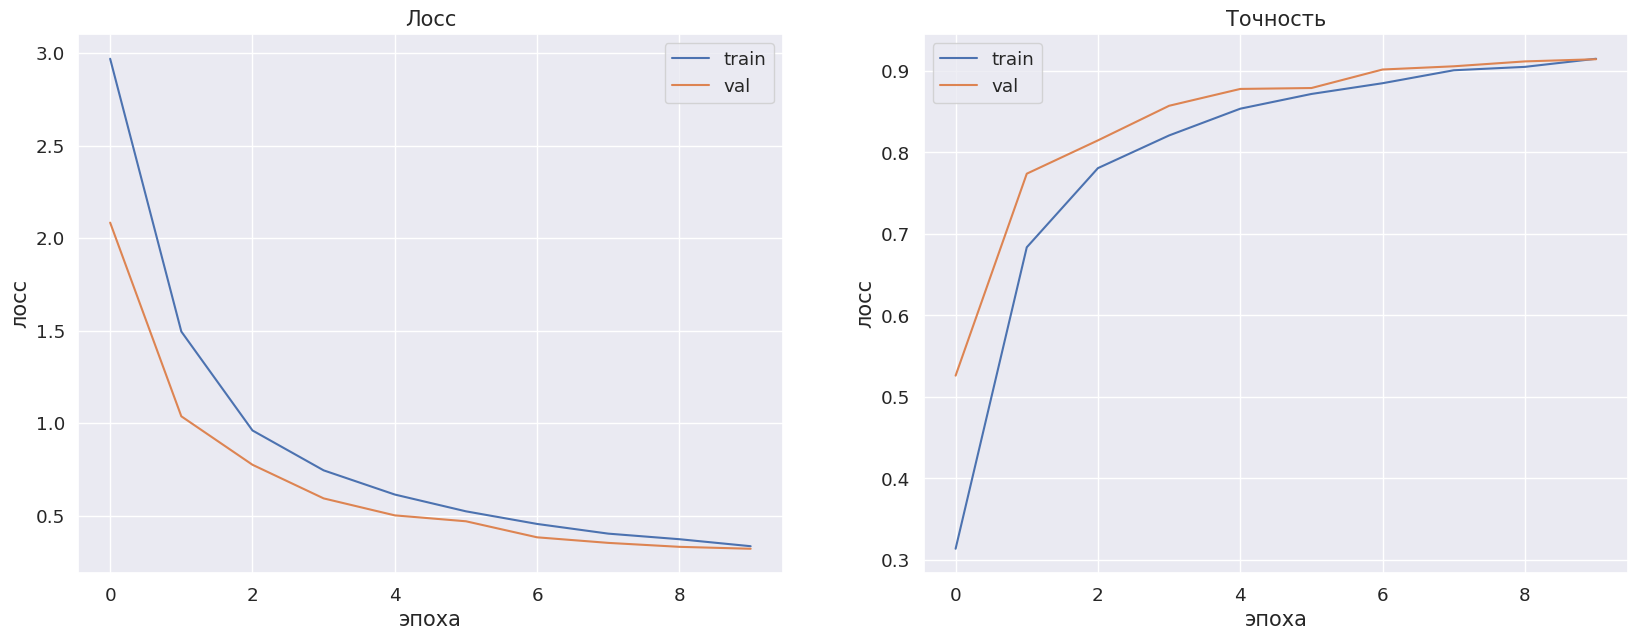

In [ ]:
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

clf_model, history = train(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

**В целом мы видим, что обучение можно было оставновить уже на 6 эпохе. Так и поступим для следующих моделей**

# **Используем LR Scheduler StepLR**

In [ ]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2)

In [ ]:
def train_scheduler(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Добавляем LR Scheduler
        scheduler.step()

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        plot_learning_curves(history)

    return model, history

In [ ]:
torch.cuda.empty_cache()
gc.collect()

3967

In [ ]:
torch.cuda.empty_cache()
gc.collect()

0

Epoch 6 of 6 took 120.416s
  training loss (in-iteration): 	0.523294
  validation loss (in-iteration): 	0.425361
  training accuracy: 			87.37 %
  validation accuracy: 			89.36 %


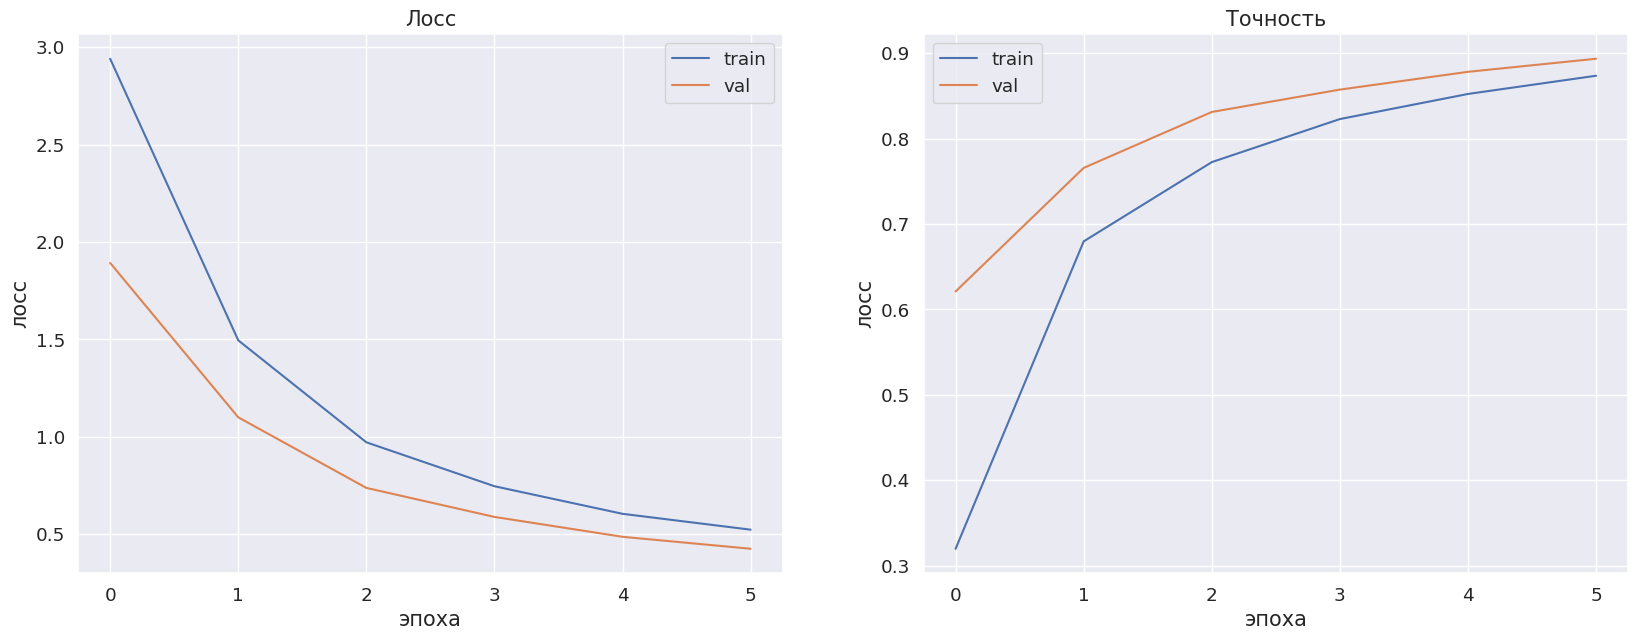

In [ ]:
model = mobilenet_v3_small(pretrained=True)
model.classifier[3] = nn.Linear(in_features=1024, out_features=42)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

clf_model, history = train_scheduler(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=6
)

**В целом модель отработала более стабильно, не было просадки на 5 эпохе, но большого прироста в качестве не наблюдается**

# **Используем LR Scheduler ExponentialLR**

In [ ]:
torch.cuda.empty_cache()
gc.collect()

8

In [ ]:
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)

Epoch 6 of 6 took 120.374s
  training loss (in-iteration): 	0.515675
  validation loss (in-iteration): 	0.447212
  training accuracy: 			87.29 %
  validation accuracy: 			88.98 %


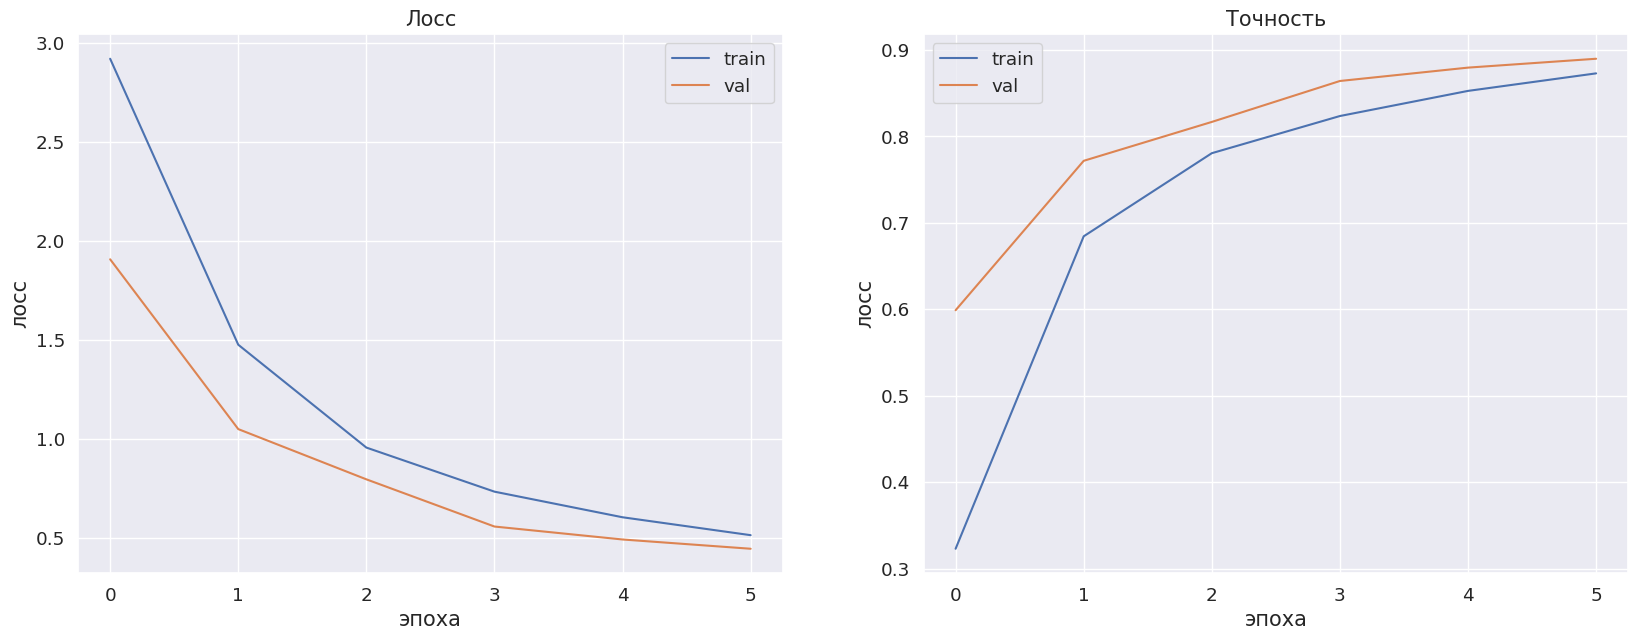

In [ ]:
model = mobilenet_v3_small(pretrained=True)
model.classifier[3] = nn.Linear(in_features=1024, out_features=42)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

clf_model, history = train_scheduler(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=6
)

**Модель чуть быстрее обучается при ExponentialLR**

# **Применим некорректую аугментацию**

In [ ]:
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ColorJitter(brightness=.5, hue=.3),
    transforms.RandomCrop(input_size),
    transforms.ElasticTransform(alpha=250.0),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

In [ ]:
sns.set_style(style='white')

def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=2, ncols=3, figsize=(8, 6),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=6000)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))

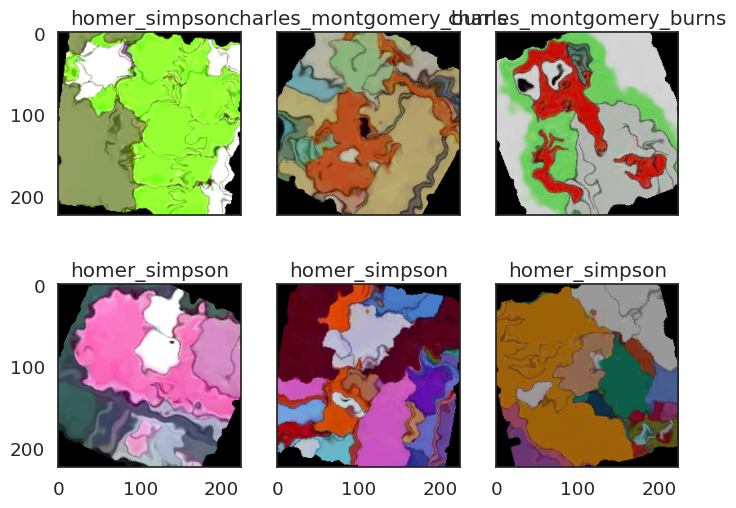

In [ ]:
show_images(train_dataset)

In [ ]:
batch_size = 64

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

**Проверим данные на последней модели с LR Scheduler ExponentialLR**

In [ ]:
torch.cuda.empty_cache()
gc.collect()

3894

In [ ]:
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)

Epoch 6 of 6 took 407.743s
  training loss (in-iteration): 	1.707739
  validation loss (in-iteration): 	1.504254
  training accuracy: 			54.89 %
  validation accuracy: 			62.77 %


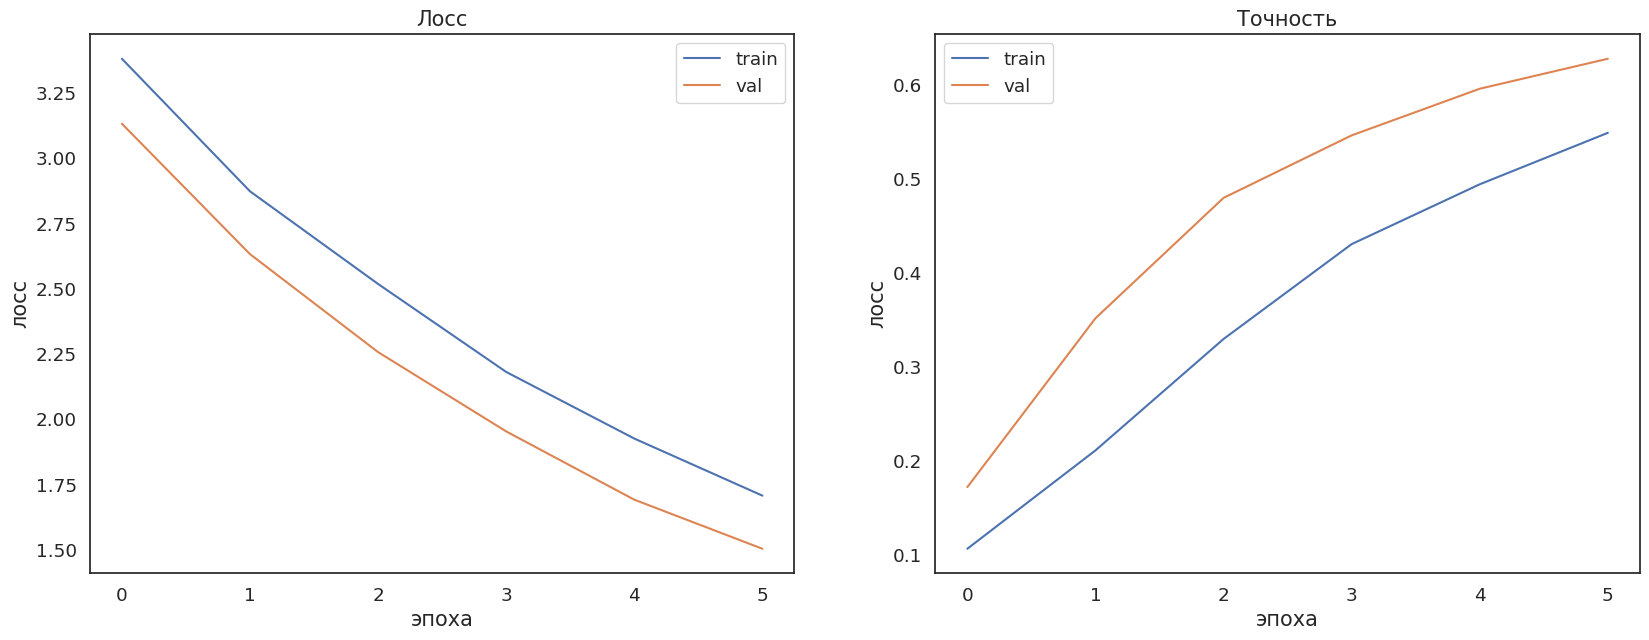

In [ ]:
model = mobilenet_v3_small(pretrained=True)
model.classifier[3] = nn.Linear(in_features=1024, out_features=42)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

clf_model, history = train_scheduler(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=6
)

**Выводы:**

Аугментация существенно влияет на обучение, некоретно подобранная аугментация существенно усложняет работу модели. Так же аугментация влияет на скорость обучения, мы видим что в последнем примере время обучения выросло в разы в сравнении с базовой моделью.
В даной задаче при использовании предобученой модели MobileNet чуть лучшее качество показала ExponentialLR